In [58]:
import pandas as pd     # 数据表
import numpy as np     # 数组
import re     # 正则表达式
import jieba     # 中文分词
import matplotlib.pyplot as plt     # 画图
from gensim.models import Word2Vec     # 训练词嵌入模型
# import gensim.downloader as api     # 导入云端的已训练好的词向量
# from gensim.models import KeyedVectors     # 加载自己本地个性化的已训练好的词向量
from sklearn.metrics.pairwise import cosine_similarity     # 计算向量之间的余弦相似度
from sklearn.decomposition import PCA     # 语义空间降维，用于展示词语在二维空间的相对位置

In [105]:
df = pd.read_excel('text_analysis_ad.xlsx', index_col = 0)

In [108]:
df.head()

index                                              商品名称  商品类别   出版年  \
0   1596                                五华牌香烟[May Blossom]  烟草制品  1932   
1   5627  韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People]    药品  1918   
2  13532                   大炮台香烟[Three Castles Cigarettes]  烟草制品  1935   
3   1133                                婴孩自己药片[Baby's Own]    药品  1930   
4   3146                                     亚士北罗药片[Aspro]    药品  1933   

                                                广告文本  \
0  兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟  二十枝装每包售国币大洋二角 五十枝装每罐售国币...   
1  讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...   
2                                  香味馥郁,不让名花 另有三炮台出售   
3  差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...   
4  何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...   

                              广告标题  
0    五华牌香烟,"兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟"  
1        韦廉士红色清导丸:'讲求卫生为人生本性天理固然也'  
2                大炮台香烟,"香味馥郁 不让名花"  
3  婴孩自己药片,"差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片"  
4                   亚士北罗药片,"妇女之腻友"

### 语料预处理

#### 剔除符号与数字

In [23]:
def remove_nums(text):
    nonums = re.sub('[^\u4e00-\u9fa5]+', '', text)
    return nonums
test = df['广告文本'][0]
remove_nums(test)

'苏俄世界著名専利出品全权代表上海协助会洋行香港广东总经理礼和洋行杀虫特效药购买时请认明山道寕商标'

#### 分词

In [38]:
# 加载中文停用词词典，可个性化设置
stopwords = open('stopwords.txt', encoding = 'utf-8').read()

def clean_text(text):
    words = jieba.lcut(text)
    words = [w for w in words if w not in stopwords and w!='[' and w!=']']
    return ' '.join(words)
test = df['广告文本'][0]
clean_text(test)

'苏俄 世界 著名 専 出品 全权代表 上海 协助 洋行 香港 广东 总经理 礼 洋行 杀虫 特效药 购买 时请 认明 山道 寕 商标'

#### 预处理

In [39]:
df['广告文本分词'] = df['广告文本'].apply(remove_nums)
df['广告文本分词'] = df['广告文本分词'].apply(clean_text)
df

index                                              商品名称    商品类别   出版年  \
0    4401                                          山道宁杀虫特效药  化肥及杀虫剂  1935   
1    6097                                        韦廉士医生红色清导丸      药品  1918   
2    2982                                        加当[Gardan]      药品  1933   
3    4101  韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People]      药品  1934   
4    3989                                             旁氏白玉霜      药品  1934   
..    ...                                               ...     ...   ...   
95   5674                                        仁丹[Jintan]      药品  1918   
96   9505  韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People]      药品  1923   
97  14753                                      中将汤[Chujoto]      药品  1935   
98   9539                                           爱兰百利代食粉     乳制品  1923   
99   6826                                        仁丹[Jintan]      药品  1919   

                                                 广告文本  \
0   苏俄世界著名専利出品 全权代表 上海协助会洋行 香港广东总经理 礼和洋行 杀虫特效药购买时请...   
1   看来神气充足自覚康健无疾也 逐日大肠有序神清气爽矣若大便闭结肝经失调之原由即起头痛肝肠上升口...   
2   旁佛拉文片口腔喉头消毒药能预防白喉喉痧伤风肺炎等一切传染恶症口中含化保喉防疫加当退热去风湿消...   
3   治疗便秘如用霸烈之泻药实为大错盖霸烈之泻药对于肠胃作用粗暴辄令峻泻全部消化器官乃因之而愈弱便...   
4   旁氏白玉霜 细腻滋润 色白香浓 常搽可免皮肤干糙拆裂或因日晒风吹变色 能保肌肤白嫩 容貌都丽...   
..                                                ...   
95  耑治  中暑伤寒 腹痛吐泻 头痛目眩 积痞溜饮 食积不消 水土不服 猝中昏倒 酒醉船晕 精神...   
96   清导丸甚宜于乳母  清导丸甚宜于乳母也  大便秘结其毒如血若乳母患之非但有害于彼自己之身体...   
97  妇女一生的幸福全仗有根除妇女诸病的良药扶助之能治疗妇女一切疾患及产前产后的*生剂唯有中将汤始...   
98  爱兰百利代食粉 又名参精牛乳粉凡患病者或*力为师者食之最宜 此代食粉与爱兰百利代乳粉截然不同...   
99  耑治 中暑伤寒 水土不服 腹痛吐泻 猝中晕倒 酒醉船晕 精神郁结 食积不消 时令疫疾 药界之...   

                                      广告标题  \
0                    山道宁杀虫特效药,"苏俄世界著名専利出品"   
1                 韦廉士红色清导丸:"看来神气充足自覚康健无疾也"   
2                               加当,"旁佛拉文片"   
3               韦廉士红色清导丸,"医师之良好经验用清导丸治疗便秘"   
4                  旁氏白玉霜,"旁氏白玉霜 细腻滋润 色白香浓"   
..                                     ...   
95                        仁丹:"听听四万万国民称赞之声"   
96                    韦廉士红色清导丸,"清导丸甚宜于乳母"    
97                              中将汤,"妇科霊药"   
98  爱兰百利代食粉,"爱兰百利代食粉又名参精牛乳粉凡患病者或*力为师者食之最宜"   
99                              仁丹,"药界之权威"   

                                               广告文本分词  
0   苏俄 世界 著名 専 出品 全权代表 上海 协助 洋行 香港 广东 总经理 礼 洋行 杀虫 ...  
1   神气 充足 覚 康健 无疾 逐日 大肠 有序 神清气爽 大便 闭结 肝经 失调 原由 即起 ...  
2   佛拉 文片 口腔 喉头 消毒药 预防 白喉 喉痧 伤风 肺炎 传染 恶症 口中 含化 保喉 ...  
3   治疗 便秘 如用 霸烈 泻药 实为 大错 盖 霸烈 泻药 肠胃 作用 粗暴 辄 令峻 泻 消...  
4   旁氏 白玉霜 细腻 滋润 色白 香浓 搽 可免 皮肤 干糙 拆裂 日晒 风吹 变色 能保 肌...  
..                                                ...  
95  耑 治 中暑 伤寒 腹痛 吐泻 头痛 目眩 积痞 溜 饮食 不消 水土不服 猝中 昏倒 酒醉...  
96  清导丸 宜于 乳母 清导丸 宜于 乳母 便秘 结其毒 如血 乳母 患 有害 身体 亦 有损于...  
97  妇女 一生 幸福 全仗 根除 妇女 诸病 良药 扶助 之能 治疗 妇女 疾患 及产前 产后 ...  
98  爱兰 百利 代食粉 又名 参精牛 乳粉 凡 患病者 或力 师者 食 最宜 此代食 粉 爱兰 ...  
99  耑 治 中暑 伤寒 水土不服 腹痛 吐泻 猝中 晕倒 酒醉 船晕 精神 郁结 食积 不消 时...  

[100 rows x 7 columns]

### 词嵌入

#### 原理解读

词向量（Word Vectors）是将词语映射到向量空间，使其成为向量空间中的一个点。在这个空间中，语义上相似的单词在空间中的距离也相近。在这个向量空间中，每个词语都用一个向量表示，这个向量是多维的，并且每一维都是一个实数。这就是所谓“单个词语的词向量”。

使用词向量，我们可以进行各种文本分析任务，如文本分类、情感分析、文本相似度计算等。通过计算两个词向量之间的余弦相似度，我们可以得到这两个词语在语义上的相似度。

#### 使用词嵌入模型（给出3种方法）

In [63]:
# 加载预训练Word2Vec模型
# 注意：云端下载需要联网，因而需要在网络连接畅通的环境下进行
# 另外，初次加载该模型可能会耗费一定时间，具体时间长短取决于网络连接状况
# 样例：
# w2v_model = api.load('word2vec-google-news-300')


# 加载本地的预训练Word2Vec模型，需要提前下载好
# 样例：
# w2v_model = KeyedVectors.load_word2vec_format('sgns.sikuquanshu.word', binary = False)


# 自己训练词嵌入模型
corpus = df['广告文本分词'].apply(lambda x: x.split()).tolist()     # 切分词语
model = Word2Vec(corpus,     # 喂词
                 vector_size = 100,     # 自定义训练向量维度
                 window = 5,     # 训练算法考虑的当前词语与预测词语在一个句子中的最大距离（窗口大小）
                 min_count = 1,     # 忽略所有总频数低于这个值的词语
                 workers = 4)     # 用于训练的线程数
# 保存训练好的模型
model.save('ad_word2vec_model.model')

In [67]:
vocab = model.wv.index_to_key  # 获取词汇表
word_vectors = model.wv[vocab]  # 获取词向量

# 打印词汇表和对应的词向量
for word, vector in zip(vocab, word_vectors):
    print(f'{word}: {vector}')

医生: [-2.30218284e-03  3.46279074e-03  6.71034306e-03  1.00387307e-02
 -9.87587497e-03 -9.70305409e-03  8.04159138e-03  1.27402619e-02
 -6.90954691e-03 -6.04091678e-03  7.73361837e-03 -4.72302036e-03
 -3.63618927e-03  8.12316686e-03 -3.78772570e-03 -2.78236833e-03
  3.82660609e-03 -6.87453139e-04 -8.68399814e-03 -1.37195140e-02
  9.25972778e-03  6.38972595e-03  8.88881367e-03  3.27193411e-04
  7.15601677e-03 -2.33604969e-03 -1.90735061e-03  5.32432692e-03
 -9.05562099e-03 -4.48559411e-03 -5.82558336e-03 -8.39703134e-04
  1.04372567e-02 -9.59882699e-03 -3.20970360e-03  5.47006493e-04
  8.74521025e-03 -6.62817527e-03 -1.06937450e-03 -7.60259945e-03
 -9.66745242e-03  3.56738479e-03 -1.04813501e-02 -5.09822741e-03
  1.09282066e-03 -1.64075487e-03 -1.00717405e-02  9.54857655e-03
  5.25465561e-03  1.16259884e-02 -7.61512574e-03  2.39609019e-03
 -6.81776833e-03  1.16518897e-03  8.35594069e-03 -3.72782163e-03
  6.52588485e-03 -7.65654398e-03 -5.62882889e-03  1.06068254e-02
 -2.07828311e-03  3.4

In [92]:
# 检查词嵌入模型中任意两个词向量的余弦相似度，即语义接近性
# 余弦相似度的取值介于[-1, 1]之间，-1表示语义完全相反，1表示语义完全相同，0表示毫无关系
# model.sv.similarity这个函数与np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))的输出结果一致
print(model.wv.similarity('医生', '疼痛'))
print(model.wv.similarity('医生', '神经'))
print(model.wv.similarity('医生', '伤风'))
print(model.wv.similarity('疼痛', '神经'))
print(model.wv.similarity('疼痛', '伤风'))
print(model.wv.similarity('神经', '伤风'))

0.09569763
0.1402376
-0.08912665
0.0067945523
-0.04887424
-0.013621764


#### 可视化

In [72]:
# 可视化
words = ['医生', '疼痛', '神经', '伤风']
vectors = [model.wv[word] for word in words]

# 使用PCA进行降维
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(vectors)

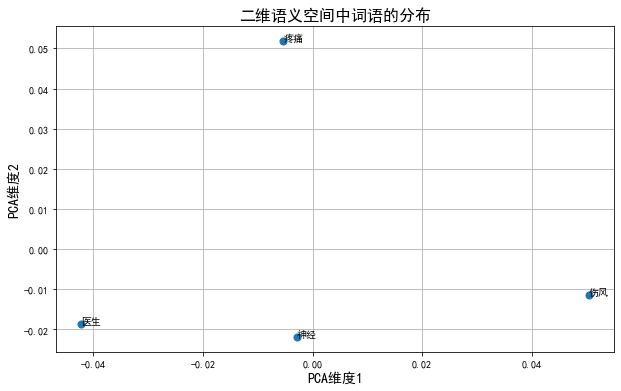

In [81]:
# 绘制四个词语在二维空间的相对位置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (10, 6))
# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s = 50)

for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('PCA维度1', fontsize = 14)
plt.ylabel('PCA维度2', fontsize = 14)
plt.title('二维语义空间中词语的分布', fontsize = 16)
plt.grid(True)
plt.show()